# Join 平台眾開講

Things tried so far:

* Simple deep dense model
* A simple CNN

A few things to try next:

* Split data to sentences and re-label them.  Remove duplicated data.  Remove URLs, tagging users, ～ 👍.
* RNN, since the comments tend to be short and paragraph-less.
* LRP to explain classifications
* fastText

## Setup

In [1]:
path = "data/join"
topic = "立法方式保障"
# topic = "同性伴侣法"
# topic = "同性婚姻法"

In [2]:
from __future__ import division, print_function
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import jieba
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization, Conv1D, ZeroPadding1D
import os, math, re

jieba.set_dictionary(os.path.join("data", "dict.txt.big"))

Using TensorFlow backend.
/Users/pm5/.local/share/virtualenvs/ggv-example-1H9VW0Dl/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Read in messages from CSV.

In [40]:
def get_messages_from_orig(topic):
    messages = pd.read_csv(os.path.join(path, topic + ".csv"), index_col=0)
    mask = messages.astype('str').applymap(lambda x: len(x.decode('utf-8'))).content > 20
    messages = messages[mask]
    messages.to_csv(os.path.join(path, topic + "-good.csv"))
    return messages

def get_labeled_messages(topic):
    return pd.read_csv(os.path.join(path, topic + "-good.csv"), index_col=0)

def labeled_only(messages):
    return messages[messages.ORID.notnull()]

def unlabeled_only(messages):
    return messages[messages.ORID.isnull()]
    
all_messages = get_messages_from_orig(topic) if not os.path.exists(os.path.join(path, topic + "-good.csv")) \
                                         else get_labeled_messages(topic)
messages = labeled_only(all_messages)

Build dictionary of phrases and load word embeddings.

In [7]:
def write_dictionary(messages):
    contents = [ jieba.lcut(c) for c in messages.content ]
    all_phrases = set([ ph for c in contents for ph in c ])
    with open(os.path.join(path, "dictionary.txt"), "w") as fh:
        for ph in all_phrases:
            fh.write(ph + "\n")
            
def read_dictionary():
    dictionary = pd.read_csv(os.path.join(path, "dictionary.vec"), 
                       delim_whitespace=True, engine="python", header=None, index_col=0)
    return dictionary

if not os.path.exists("dictionary.vec"):
    write_dictionary(all_messages)
    !cd data/join; ~/bin/fasttext print-word-vectors models/wiki.zh.bin < dictionary.txt > dictionary.vec
dictionary = read_dictionary()

Build dictionary index to convert phrases into embedding vectors.

In [9]:
dict_index = { ph: i for i, ph in enumerate(dictionary.index) }

Split messages into training and validation datasets by 4:1.

In [10]:
select = np.random.random(len(messages)) < 0.8
train = messages[select]
valid = messages[~select]

Show the data.

In [11]:
print("Total messages: {count}".format(count=len(all_messages)))
print("Labeled messages: {count}".format(count=len(messages)))
messages.head()

Total messages: 10215
Labeled messages: 277


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN


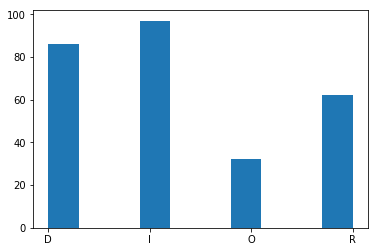

In [12]:
plt.hist(messages.ORID.values)
plt.show()

In [13]:
dictionary.shape, dict_index[u"同性"], (dictionary.iloc[dict_index[u"同性"]] == dictionary.loc["同性"]).all()

((35697, 300), 8454, True)

In [14]:
dictionary

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
榴槤,-0.317640,-0.136970,0.100460,0.216450,0.718370,-0.663020,-0.031587,-0.394080,0.405530,0.250280,...,-0.042232,1.230000,0.741880,0.512620,-0.411960,0.964950,0.299250,-0.115530,0.386200,0.679790
蒙,-0.342780,-0.250160,-0.014444,-0.602880,0.152570,-0.083092,0.249650,-0.038862,-0.222640,0.130790,...,0.036234,1.312400,0.801980,-0.210870,-0.526750,1.459300,1.539900,-0.011787,-0.415620,0.086354
我領,0.173790,-0.053141,-0.026261,0.070228,0.299480,-0.203580,0.060699,-0.081881,0.015293,-0.213600,...,-0.282370,0.769660,0.446350,0.019647,-0.503240,0.490360,0.694250,0.127790,0.282680,0.160470
接種,-0.045745,-0.143280,0.086597,0.270700,0.245910,-0.086427,0.002235,0.209720,-0.017877,0.318820,...,-0.272750,1.065800,0.546570,0.100010,-0.222090,0.623880,1.084200,-0.704620,0.447690,0.301860
人生價值,-0.010342,-0.298870,-0.059768,-0.154300,-0.077716,0.075155,0.120470,-0.052568,0.027297,0.016555,...,-0.474980,0.632570,0.300020,0.213530,-0.076498,0.384910,0.433670,0.258180,0.441160,0.268660
健身房,0.072460,-0.195950,-0.263070,-0.692830,0.429820,-0.401950,-0.539300,0.157670,0.037588,0.057012,...,0.142770,0.366020,0.384510,0.346230,-0.825660,0.511900,0.319080,0.099065,0.011140,0.560700
遇過,0.169210,-0.076102,-0.075849,0.469510,0.288850,-0.227760,-0.082191,-0.117260,-0.231780,0.016380,...,-0.343520,0.740340,0.307340,-0.025568,-0.297060,0.144320,0.696970,0.202560,0.214710,0.953150
空調,0.502020,0.331230,-0.260470,-0.184650,0.379080,-0.229690,0.069507,-0.489360,-0.383660,0.096540,...,-0.935190,0.547580,0.502570,0.075498,0.057618,0.994110,0.836120,-0.171000,-0.271140,0.976280
會命,0.019032,0.210730,-0.143610,0.102530,-0.188490,-0.110360,-0.050336,-0.073101,-0.052906,0.149480,...,-0.238390,0.970080,0.654400,0.259220,-0.212960,0.730600,0.658540,-0.099452,0.370730,0.555710


In [15]:
print("Training data: {count}".format(count=len(train)))
train.head()

Training data: 213


,createDate,authorName,content,ORID,comments
id,,,,,
14136,2015-08-03 8:57:21,Shaffer Lin,「政府對全體人民的人權有履行義務且不應以公眾之意見作為履行的條件」那現在在投什麼？自打嘴巴？...,R,NaN
14135,2015-08-03 9:30:52,Oliver Lin,贊成歸贊成但更贊成就直接修民法就好了不用疊床架屋我要的沒有比較特別就是現在一堆人在結的那個婚姻,D,NaN
14134,2015-08-03 10:05:26,蛍一 森里,與其以立法的方式來保障不如用修法的方式來保障不是比較方便一些?,I,NaN
14133,2015-08-03 10:08:00,楊剛,投你個花開富貴啦我要不要結婚關順性別異性戀沙豬什麼事啊？啊連個草案都沒有的東西是要投三小喔？...,R,NaN
14132,2015-08-03 10:14:57,黑桐喵,原來別人要不要結婚須要所有人一起投票決定。既然都說了「政府對全體人民的人權有履行義務且不應以...,R,NaN


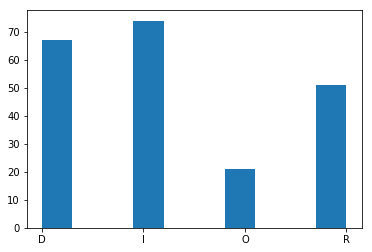

In [16]:
plt.hist(train.ORID.values)
plt.show()

In [17]:
print("Validation data: {count}".format(count=len(valid)))
valid.head()

Validation data: 64


,createDate,authorName,content,ORID,comments
id,,,,,
14125,2015-08-03 16:22:54,Rich,難道異性戀就沒有不孕症？異性戀也有代理孕母！不孕症的也有買小孩的事，這些不需要冠在同性戀身上...,R,NaN
14101,2015-08-04 4:00:00,RED,參考國外已上路的同性婚姻可見，在同性婚姻合法化並制定在原婚姻法基礎上，非專案法管理，結果是雙...,I,NaN
14092,2015-08-04 4:52:19,王冠文,你是在說護家盟嗎拜託他們常常上網發文攻擊同志族群好嗎哪來廣大的沈默,I,NaN
14090,2015-08-04 4:57:43,黃道明,正義之士都會尊重同志並且支持同志擁有結婚權，只有會歧視的反同人士才會反對，並且侮辱同志，並且...,I,NaN
14075,2015-08-04 6:24:30,Chihhan Lin,支持平等，但反對立專法。婚姻平權是不分生理、心理性別傾向，異性戀婚姻與同性戀婚姻也是如此。台灣加油,D,NaN


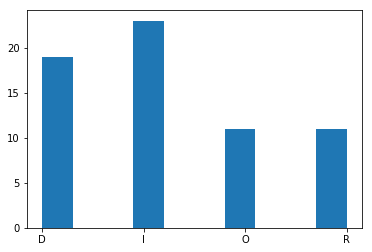

In [18]:
plt.hist(valid.ORID.values)
plt.show()

Setup input length and word embeddings.

In [19]:
input_length = 140

def create_embeddings(dictionary, input_length=100):
    phrases, latents = dictionary.shape
    embedding = Embedding(phrases, latents, input_length=input_length, weights=[dictionary], trainable=False)
    return embedding

In [21]:
def get_data(messages):
    jieba_cut = np.frompyfunc(lambda x: [ ph for ph in jieba.lcut(x) if ph != u" " ][:input_length], 1, 1)
    word_embed = np.frompyfunc(lambda x: [ dict_index[ph] for ph in x ], 1, 1)
    fill_to_length = np.frompyfunc(lambda x: x + [0] * (input_length - len(x)), 1, 1)
    return np.stack(fill_to_length(word_embed(jieba_cut(messages.content.values))), axis=0)

answers_oh = { "O": [1., 0., 0., 0.], "R": [0., 1., 0., 0.], "I": [0., 0., 1., 0.], "D": [0., 0., 0., 1.] }

def orid_to_oh(x): return answers_oh[x]

def get_answer(messages):
    return np.array([ orid_to_oh(x) for x in messages.ORID ])

train = (get_data(train), get_answer(train))
valid = (get_data(valid), get_answer(valid))

In [22]:
train[0][10], train[1][10], valid[0][0], valid[1][0]

(array([ 1825, 11918, 29589,  4454,  8454, 24790, 20505,  5652,  8808,
        28741,  1646,  5599, 12699, 23884, 19684,  2124,  4201, 12782,
         8808, 11885, 35063,  4170, 27432, 30306, 14929, 30249, 30249,
        21377,  8817, 11918, 29135, 11918, 29589,  4454, 23862,  3473,
         1646,  5599, 31796,  7241, 21355, 16886,  1646, 10907,  7896,
        22067, 10234, 18674, 20505, 31051, 11918, 13908, 11918, 19732,
        18865,  7362, 16886, 23884, 12824, 11918,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

# Single hidden layer model

In [127]:
batch_size = 64

def simple_nn_model():
    model = Sequential()
    model.add(create_embeddings(dictionary, input_length))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))
    return model

simple_nn = simple_nn_model()
simple_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_24 (Embedding)         (None, 140, 300)      10710000    embedding_input_24[0][0]         
____________________________________________________________________________________________________
flatten_12 (Flatten)             (None, 42000)         0           embedding_24[0][0]               
____________________________________________________________________________________________________
batchnormalization_36 (BatchNorm (None, 42000)         168000      flatten_12[0][0]                 
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 256)           10752256    batchnormalization_36[0][0]      
___________________________________________________________________________________________

In [128]:
simple_nn.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [129]:
def train_simple_nn(lr=None, epoch=1):
    if lr is not None:
        simple_nn.optimizer.lr = lr
    simple_nn.fit(train[0], train[1], nb_epoch=epoch, validation_data=valid, batch_size=batch_size)


In [130]:
train_simple_nn()
train_simple_nn(lr=1e-1, epoch=2)
train_simple_nn(lr=1e-4, epoch=2)

Train on 229 samples, validate on 48 samples
Epoch 1/1
229/229 [==============================] - 4s - loss: 1.9536 - acc: 0.3057 - val_loss: 4.1164 - val_acc: 0.1458
Train on 229 samples, validate on 48 samples
Epoch 1/2
229/229 [==============================] - 2s - loss: 1.2372 - acc: 0.4978 - val_loss: 2.4654 - val_acc: 0.2917
Epoch 2/2
229/229 [==============================] - 2s - loss: 1.1794 - acc: 0.5197 - val_loss: 2.0777 - val_acc: 0.3333
Train on 229 samples, validate on 48 samples
Epoch 1/2
229/229 [==============================] - 2s - loss: 1.0414 - acc: 0.5677 - val_loss: 1.6665 - val_acc: 0.1875
Epoch 2/2
229/229 [==============================] - 2s - loss: 0.9333 - acc: 0.6288 - val_loss: 1.8916 - val_acc: 0.2500


# CNN

In [33]:
batch_size = 64

def cnn_model():
    model = Sequential()
    model.add(create_embeddings(dictionary, input_length))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 7, border_mode="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 7, border_mode="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.7))
    model.add(Dense(4, activation="softmax"))
    return model

cnn = cnn_model()
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_4 (Embedding)          (None, 140, 300)      10709100    embedding_input_4[0][0]          
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 140, 300)      0           embedding_4[0][0]                
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 140, 300)      1200        dropout_10[0][0]                 
____________________________________________________________________________________________________
convolution1d_7 (Convolution1D)  (None, 140, 128)      268928      batchnormalization_10[0][0]      
___________________________________________________________________________________________

In [34]:
cnn.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

def train_cnn(lr=None, epoch=1):
    if lr is not None:
        cnn.optimizer.lr = lr
    cnn.fit(train[0], train[1], nb_epoch=epoch, validation_data=valid, batch_size=batch_size)

In [35]:
train_cnn()
train_cnn(0.01, 8)
train_cnn(0.001, 8)

Train on 213 samples, validate on 64 samples
Epoch 1/1
213/213 [==============================] - 4s - loss: 6.2830 - acc: 0.2629 - val_loss: 2.5944 - val_acc: 0.1406
Train on 213 samples, validate on 64 samples
Epoch 1/8
213/213 [==============================] - 3s - loss: 9.8228 - acc: 0.2911 - val_loss: 10.2438 - val_acc: 0.1875
Epoch 2/8
213/213 [==============================] - 3s - loss: 9.6389 - acc: 0.3709 - val_loss: 10.7181 - val_acc: 0.2031
Epoch 3/8
213/213 [==============================] - 3s - loss: 9.5575 - acc: 0.3944 - val_loss: 11.4228 - val_acc: 0.2812
Epoch 4/8
213/213 [==============================] - 3s - loss: 9.7262 - acc: 0.3897 - val_loss: 11.5488 - val_acc: 0.2656
Epoch 5/8
213/213 [==============================] - 3s - loss: 9.9130 - acc: 0.3850 - val_loss: 11.5931 - val_acc: 0.2812
Epoch 6/8
213/213 [==============================] - 3s - loss: 9.6692 - acc: 0.3944 - val_loss: 11.5849 - val_acc: 0.2812
Epoch 7/8
213/213 [==============================]

In [37]:
cnn.save_weights(os.path.join(path, "models/cnn.h5"))

# Evaluation

In [38]:
#model = simple_nn
model = cnn

In [39]:
results = unlabeled_only(all_messages).copy()
test_data = get_data(results)
pred = model.predict(test_data, batch_size=batch_size)
orid_fn = np.frompyfunc(lambda x, m: ["O", "R", "I", "D"][x]  if m > 0.8 else "", 2, 1)
pred_orid = orid_fn(np.argmax(pred, axis=1), np.max(pred, axis=1))
results.loc[:, "prediction"] = pd.Series(pred_orid, index=results.index)
results

KeyError: '\u3000'

In [ ]:
results[results.prediction == "O"]

In [ ]:
results[results.prediction == "R"]

In [ ]:
results[results.prediction == "I"]

In [ ]:
results[results.prediction == "D"]